In [27]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax, random, vmap
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, MCMC, NUTS

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../../src/')

from models.inference import run_mcmc_inference, check_mcmc_inference
from models.prediction import get_ppc

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 肉まんの販売個数に関する分析

特定の時間帯で二週間の肉まんの売上を10店舗に対して獲得している。また、各日の気温のデータも取得されており、

In [28]:
data = pd.DataFrame({
    
    'temperature':[13.2,  2.7,  8.7,  4.5, 10.8, 13.8,  6.2,  5.8,  2.5,  7. , 13.2,
        2.7,  8.7,  4.5, 10.8, 13.8,  6.2,  5.8,  2.5,  7. , 13.2,  2.7,
        8.7,  4.5, 10.8, 13.8,  6.2,  5.8,  2.5,  7. , 13.2,  2.7,  8.7,
        4.5, 10.8, 13.8,  6.2,  5.8,  2.5,  7. , 13.2,  2.7,  8.7,  4.5,
       10.8, 13.8,  6.2,  5.8,  2.5,  7. , 13.2,  2.7,  8.7,  4.5, 10.8,
       13.8,  6.2,  5.8,  2.5,  7. , 13.2,  2.7,  8.7,  4.5, 10.8, 13.8,
        6.2,  5.8,  2.5,  7. , 13.2,  2.7,  8.7,  4.5, 10.8, 13.8,  6.2,
        5.8,  2.5,  7. , 13.2,  2.7,  8.7,  4.5, 10.8, 13.8,  6.2,  5.8,
        2.5,  7. , 13.2,  2.7,  8.7,  4.5, 10.8, 13.8,  6.2,  5.8,  2.5,
        7. ],
    
    'num_sold':[0, 5, 2, 1, 0, 0, 3, 4, 5, 3, 0, 1, 1, 2, 3, 2, 3, 3, 2, 0, 1, 1,
       0, 0, 1, 0, 3, 0, 2, 2, 2, 3, 5, 2, 2, 2, 3, 1, 4, 3, 2, 6, 1, 4,
       4, 1, 5, 6, 4, 2, 3, 3, 0, 3, 1, 1, 2, 4, 3, 1, 1, 3, 1, 1, 3, 2,
       7, 3, 5, 3, 6, 3, 3, 3, 1, 0, 5, 1, 2, 4, 0, 8, 2, 5, 4, 3, 7, 8,
       7, 3, 2, 3, 0, 2, 3, 1, 1, 1, 3, 1],
    
    'store_id':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
})

In [29]:
x = data['temperature'].values
y = data['num_sold'].values

store_id = data['store_id'].values

num_stores = np.max(store_id) + 1

x_mu = np.mean(x)
x_sd = np.std(x)

x_scaled = (x - x_mu) / x_sd

In [30]:
num_days = 10

temperature = x[:num_days]
num_sold = y.reshape(num_stores, -1)

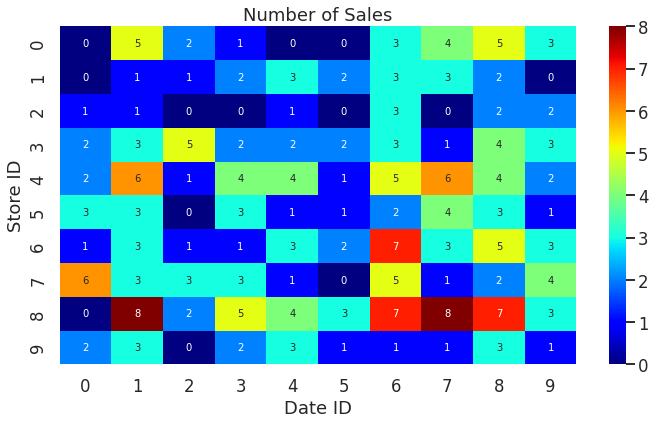

In [31]:
fig = plt.figure(figsize=(10, 6))

sns.heatmap(num_sold, annot=True, cmap='jet')

plt.title('Number of Sales')
plt.xlabel('Date ID')
plt.ylabel('Store ID')

plt.tight_layout()

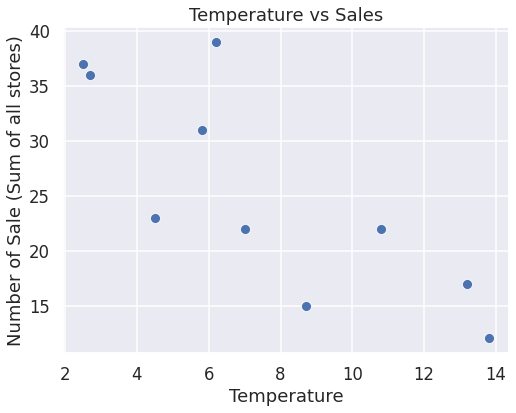

In [32]:
fig = plt.figure(figsize=(8, 6))

sns.scatterplot(x=temperature, y=num_sold.sum(axis=0), s=100)

plt.title('Temperature vs Sales')

plt.xlabel('Temperature')
plt.ylabel('Number of Sale (Sum of all stores)');

In [17]:
def model(x_scaled=None, store_id=None, y=None, num_data=0):
    
    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10))
    
    s = numpyro.sample('s', dist.HalfCauchy(5))
    r = numpyro.sample('r', dist.Normal(0, s), sample_shape=(num_stores,))
    
    theta = a * x_scaled + r[store_id] + b
    
    mu = jax.numpy.exp(theta)
        
    with numpyro.plate('data', num_data):
        
        numpyro.sample('obs', dist.Poisson(mu), obs=y)

mcmc, mcmc_samples, idata = run_mcmc_inference(model=model, x_scaled=x_scaled, store_id=store_id, y=y, num_data=len(y))

sample: 100%|██████████| 6000/6000 [00:01<00:00, 5917.79it/s, 23 steps of size 3.45e-01. acc. prob=0.91]


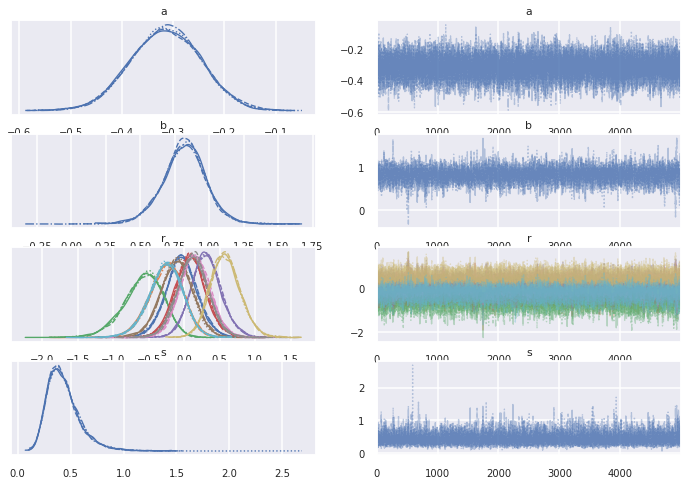

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.315,0.068,-0.439,-0.185,0.001,0.000,16059.0,13956.0,1.0
b,0.818,0.163,0.506,1.118,0.002,0.002,5289.0,6927.0,1.0
r[0],-0.038,0.227,-0.459,0.398,0.002,0.002,9042.0,10470.0,1.0
r[1],-0.258,0.243,-0.724,0.185,0.003,0.002,9493.0,9773.0,1.0
r[2],-0.579,0.283,-1.121,-0.070,0.003,0.002,9861.0,9880.0,1.0
r[3],0.088,0.223,-0.323,0.520,0.002,0.002,8592.0,9800.0,1.0
r[4],0.309,0.217,-0.090,0.730,0.002,0.002,7908.0,8544.0,1.0
r[5],-0.108,0.232,-0.545,0.324,0.002,0.002,9023.0,9786.0,1.0
r[6],0.149,0.219,-0.244,0.577,0.002,0.002,8338.0,9184.0,1.0
r[7],0.121,0.222,-0.286,0.545,0.002,0.002,8657.0,9541.0,1.0


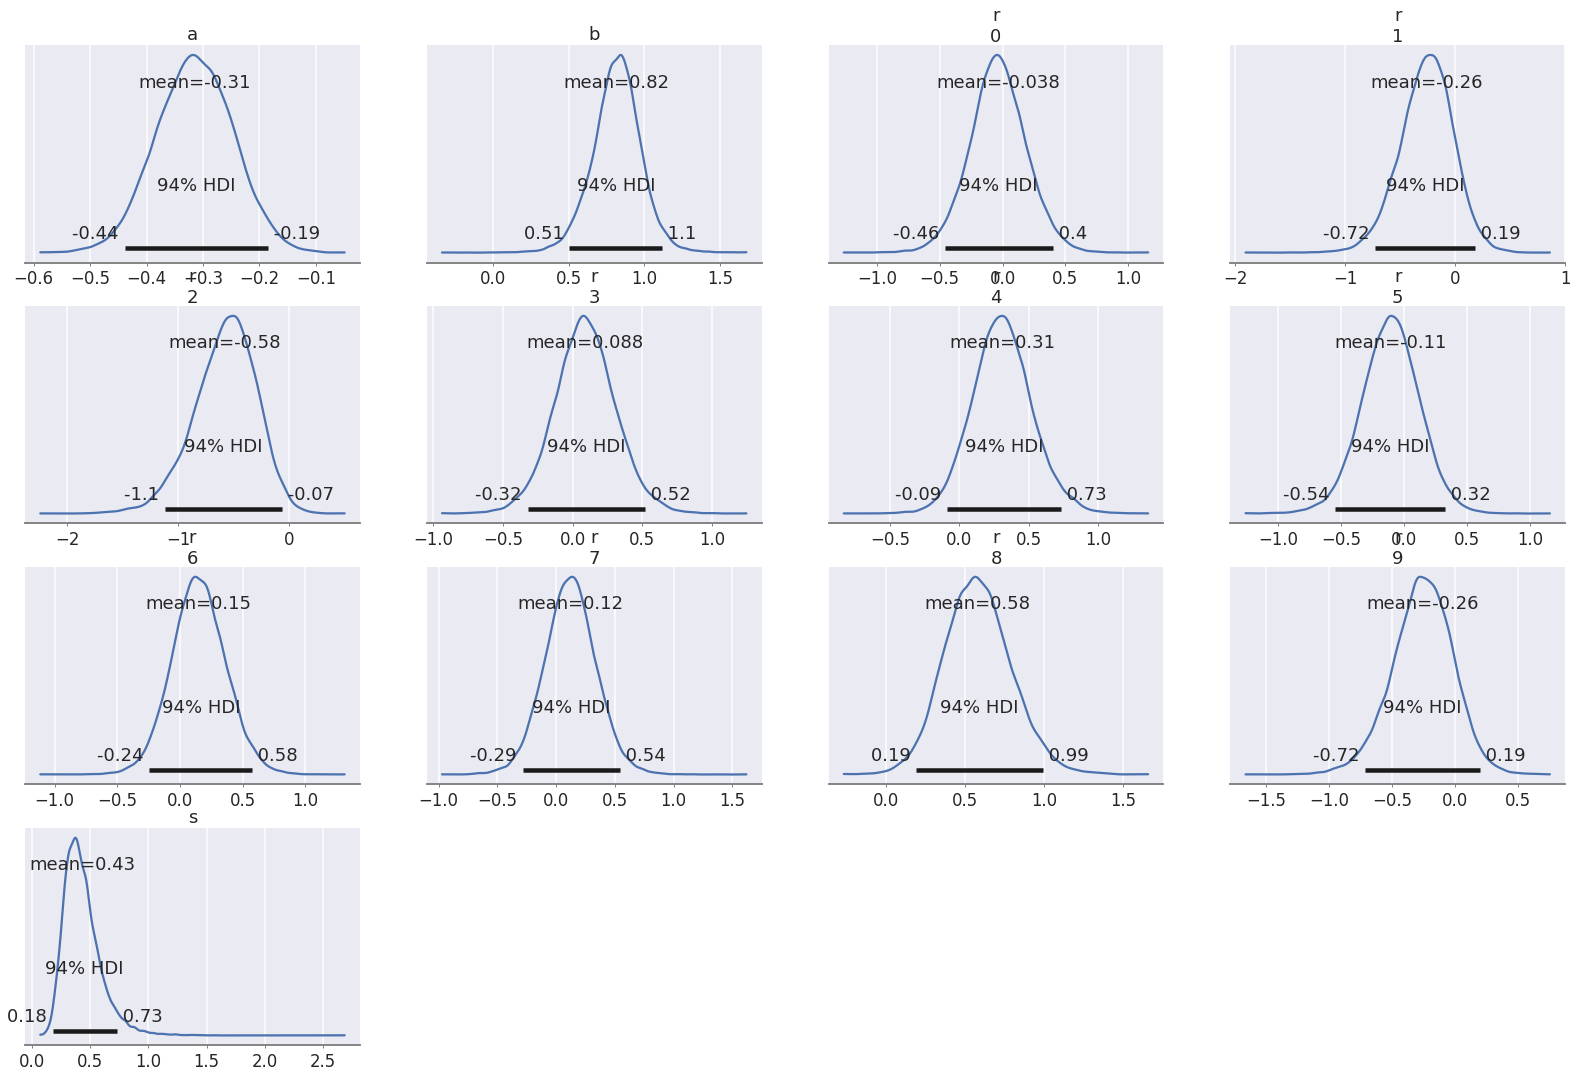

In [20]:
check_inference(idata)

In [22]:
ppc_samples, idata_ppc = get_ppc(model, mcmc, x_scaled=x_scaled, store_id=store_id, num_data=len(y))

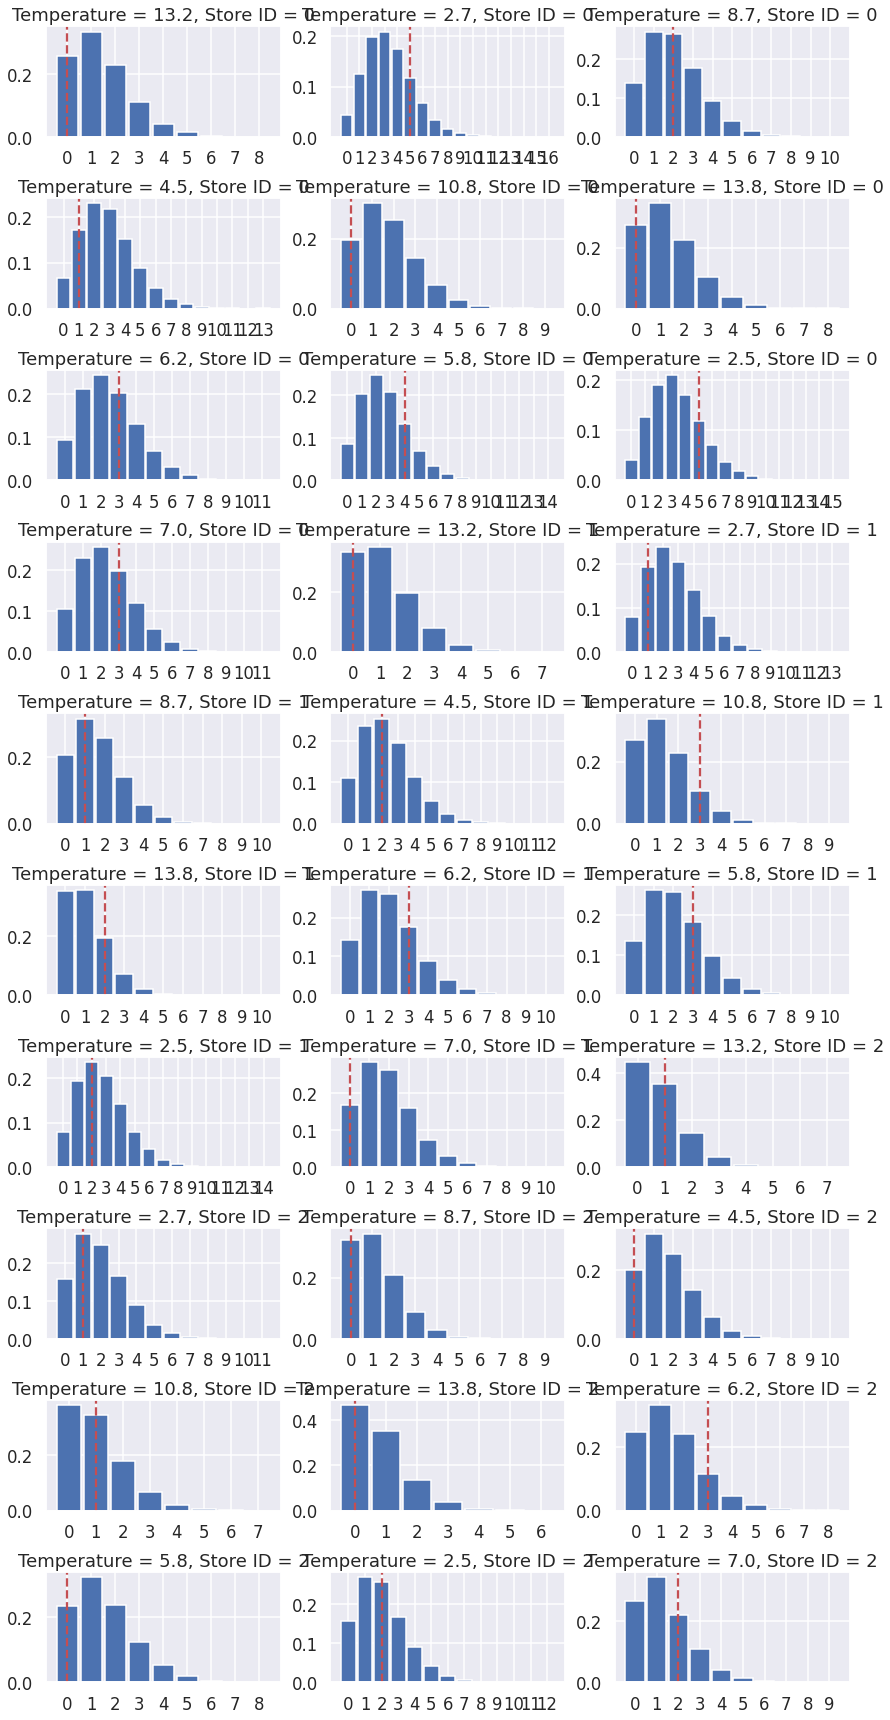

In [23]:
fig = plt.figure(figsize=(12, 24))

for k in range(30):
    
    ax = fig.add_subplot(10, 3, k+1)
    
    az.plot_dist(ppc_samples['obs'][:, k])
    ax.axvline(y[k], color='r', linestyle='dashed')
    ax.set_title('Temperature = {}, Store ID = {}'.format(x[k], store_id[k]))

plt.tight_layout()

In [24]:
x_new = np.arange(0, 20)

x_scaled_new = (x_new - x_mu) / x_sd

store_id_new = 4
store_id_dup = np.ones_like(x_new, dtype=int) * store_id_new

In [25]:
ppc_samples, idata_ppc = get_ppc(model, mcmc, x_scaled=x_scaled_new, store_id=store_id_dup, num_data=len(x_scaled_new))

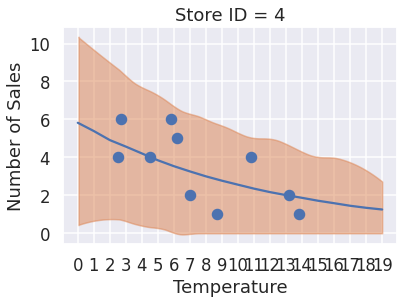

In [26]:
obs_pred = idata_ppc.posterior_predictive['obs']
obs_mean = obs_pred.mean(axis=0).mean(axis=0)

# 事後予測分布の表示
az.plot_hdi(x_new, obs_pred)
plt.plot(x_new, obs_mean)

# 観測データの表示
idx = data['store_id'] == store_id_new
plt.scatter(data[idx]['temperature'], data[idx]['num_sold'], s=100)

plt.xticks(x_new)
plt.xlabel('Temperature')
plt.ylabel('Number of Sales')
plt.title('Store ID = {}'.format(store_id_new));

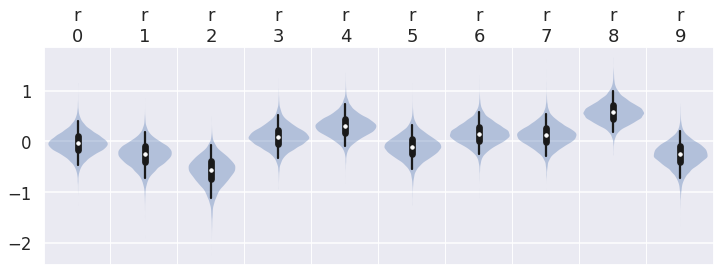

In [33]:
az.plot_violin(idata.posterior['r'], grid=(1, num_stores), figsize=(12, 4));

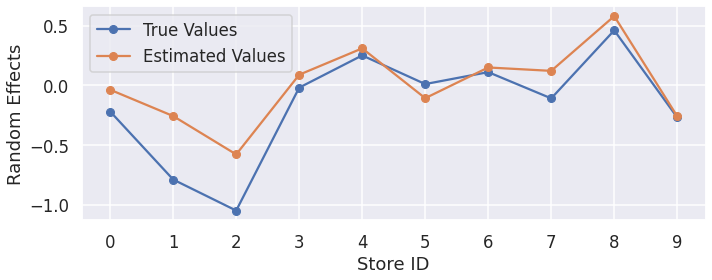

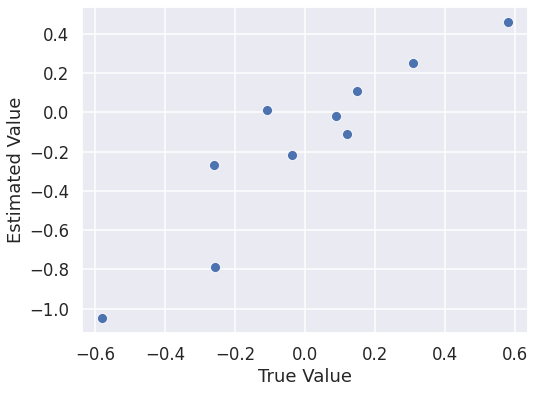

In [34]:
r_true = np.array([-0.22, -0.79, -1.05, -0.02, 0.25, 0.01, 0.11, -0.11, 0.46, -0.27])
r_mean = mcmc_samples['r'].mean(axis=0)

fig = plt.figure(figsize=(10, 4))

plt.plot(np.arange(num_stores), r_true, 'o-', markersize=8, label='True Values')
plt.plot(r_mean, 'o-', markersize=8, label='Estimated Values')
plt.xticks(np.arange(num_stores))
plt.xlabel('Store ID')
plt.ylabel('Random Effects')
plt.legend()

plt.tight_layout()


fig = plt.figure(figsize=(8, 6))

sns.scatterplot(x=r_mean, y=r_true, s=100)

plt.xlabel('True Value')
plt.ylabel('Estimated Value');

# ベイズ決定

事後予測分布に従って、売れる肉まんの数を予測し、どれだけ蒸し器に放り込むと効率的であるかを考える。

ポアソン分布：稀にしか発生しない現象を大量に観測した結果がポアソン分布に従う例は極めて多い。購買行為を誘発する要因自体は本当に無数にあるが、その中で近くのコンビニで肉まんを買う確率というのは非常に小さいが、いくつかは観測されるのでポアソン分布に従うことが期待される。

## 利益

$$
f(n,k) = 150\times\min(n,k)-50\times n
$$

肉まんの原価が50円、価格が150円。$n$は蒸し器に投入した肉まんの個数で$k$は実際に売れた肉まんとする。

いま、事後予測分布が分かっているので確率によって利益の期待値を計算することができる。

In [35]:
x_new = np.array([5])

x_scaled_new = (x_new - x_mu) / x_sd

store_id_new = np.array([6])

In [36]:
ppc_samples, idata_ppc = get_ppc(model, mcmc, x_scaled=x_scaled_new, store_id=store_id_new, num_data=len(x_scaled_new))

In [37]:
num_sales_pred = np.array(ppc_samples['obs'])

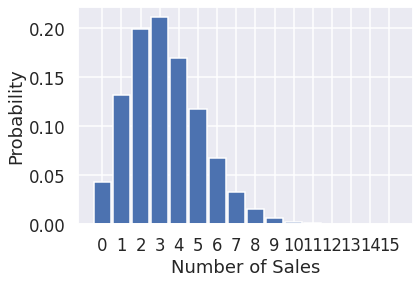

In [38]:
az.plot_dist(num_sales_pred)

plt.xlabel('Number of Sales')
plt.ylabel('Probability');

In [39]:
def estimate_profit(num_sales_pred, num_steamed):
    
    profit = np.minimum(num_sales_pred, num_steamed) * 150 - 50 * num_steamed
    
    return np.mean(profit)

num_porkbuns_to_steam = np.arange(10)

profit_estimated = [estimate_profit(num_sales_pred, k) for k in num_porkbuns_to_steam]

for k in num_porkbuns_to_steam:

    print('肉まんの個数: {}, 利益: {:3.0f}円'.format(k, np.round(profit_estimated[k])))

肉まんの個数: 0, 利益:   0円
肉まんの個数: 1, 利益:  93円
肉まんの個数: 2, 利益: 167円
肉まんの個数: 3, 利益: 211円
肉まんの個数: 4, 利益: 223円
肉まんの個数: 5, 利益: 210円
肉まんの個数: 6, 利益: 179円
肉まんの個数: 7, 利益: 138円
肉まんの個数: 8, 利益:  91円
肉まんの個数: 9, 利益:  43円


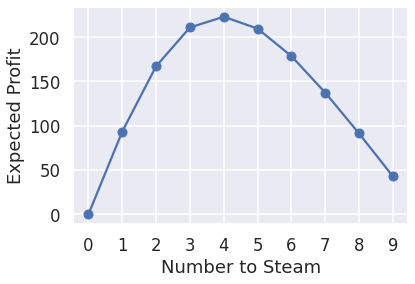

In [41]:
plt.plot(profit_estimated, 'o-')
plt.xticks(np.arange(len(profit_estimated)))

plt.xlabel('Number to Steam')
plt.ylabel('Expected Profit');

## 気温がブレるとするとどうなるか

In [44]:
x_new_mu = 5
x_new_sd = 1
x_new = np.random.normal(loc=x_new_mu, scale=x_new_sd, size=1000)

x_scaled_new = (x_new - x_mu) / x_sd

store_id_dup = np.ones_like(x_new, dtype=int) * store_id_new

In [45]:
ppc_samples, idata_ppc = get_ppc(model, mcmc, x_scaled=x_scaled_new, store_id=store_id_dup, num_data=len(x_scaled_new))

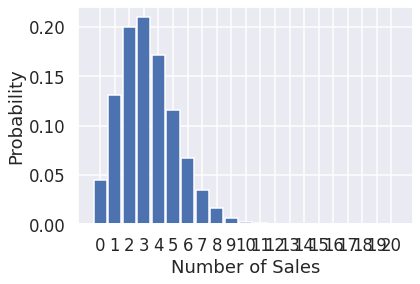

In [46]:
num_sales_pred = np.array(ppc_samples['obs'])

az.plot_dist(num_sales_pred)

plt.xlabel('Number of Sales')
plt.ylabel('Probability');

In [47]:
num_porkbuns_to_steam = np.arange(10)

profit_estimated = [estimate_profit(num_sales_pred, k) for k in num_porkbuns_to_steam]

for k in num_porkbuns_to_steam:

    print('肉まんの個数: {}, 利益: {:3.0f}円'.format(k, np.round(profit_estimated[k])))

肉まんの個数: 0, 利益:   0円
肉まんの個数: 1, 利益:  93円
肉まんの個数: 2, 利益: 167円
肉まんの個数: 3, 利益: 211円
肉まんの個数: 4, 利益: 223円
肉まんの個数: 5, 利益: 210円
肉まんの個数: 6, 利益: 179円
肉まんの個数: 7, 利益: 138円
肉まんの個数: 8, 利益:  92円
肉まんの個数: 9, 利益:  44円


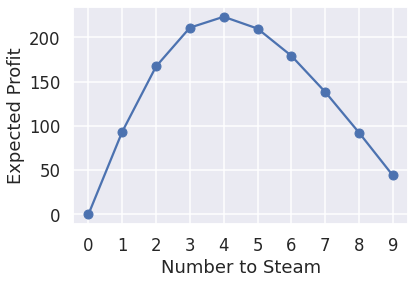

In [48]:
plt.plot(profit_estimated, 'o-')
plt.xticks(np.arange(len(profit_estimated)))

plt.xlabel('Number to Steam')
plt.ylabel('Expected Profit');